# 이미지 마스크적용(손목기준 회전,자르기)

In [1]:
from google.colab import files
uploaded = files.upload()

Saving 1.jpg to 1.jpg


In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import glob
import math

In [3]:
img = cv2.imread('1.jpg',0)

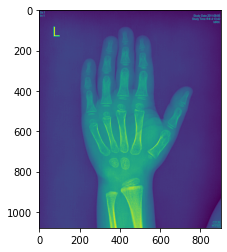

In [5]:
plt.imshow(img)

In [4]:
# 마스크 생성
def make_mask(img):
    ## 1. Lab으로 이미지 변환: 밝기 강조
    img1 = img.copy()

    img1 = cv2.cvtColor(img1, cv2.COLOR_RGB2BGR)
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2Lab)
    
    ## 2. 블러처리
    # 미디언 필터(Median filter): 주변 픽셀들의 값들을 정렬하여 그 중앙값(median)으로 픽셀 값을 대체
    # 블러의 커널 사이즈가 홀수만 가능하므로 이미지 평균 값을 기준으로 홀수값 만들기
    blur_k = int((img1.mean()*0.5)//2)*2+1
    img1 = cv2.medianBlur(img1, blur_k)
    
    ## 3. Grayscale로 이미지 변환: threshold 적용을 위함
    img1 = cv2.cvtColor(img1, cv2.COLOR_Lab2BGR)
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)

    ## 4. 이미지 평균값을 기준으로 이진화
    # cv2.threshold: 이진화함수 / 픽셀 값을 0 또는 255(1)로 만드는 연산 / th는 임계값으로 임계값이 넘어갈 시 255로 변환
    if img1.mean() > 100 : 
      th = img1.mean()*0.94
    else : 
      th = img1.mean()

    ret, img1 = cv2.threshold(img1, th, 255, cv2.THRESH_BINARY)

    ## 5. 가장 큰 값의 컨투어로 마스크 만들기
    # cv2.findContours: 외곽선 검출
        # EXTERNAL : 계층 정보 x, 바깥 외곽선만 검출
        # SIMPLE: 수직선, 수평선, 대각선에 대해 끝점만 저장
    contours, hierarchy = cv2.findContours(img1, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # cv2.drawContours: 외곽선 그리기
        # contours: (cv2.findContours() 함수로 구한) 외곽선 좌표 정보
        # contourIdx: 외곽선 인덱스. 음수(-1)를 지정하면 모든 외곽선을 그린다.
        # color: 외곽선 색상 
    max_cnt = max(contours, key=cv2.contourArea)
    mask = np.zeros(img1.shape, dtype=np.uint8)
    cv2.drawContours(mask, [max_cnt], -1, (255,255,255), -1)
    
    ## 6. 커널만들어서 팽창연산 적용: 객체외곽을 팽창
    k = cv2.getStructuringElement(cv2.MORPH_RECT, (8,8)) # 크기와 모양을 설정하고 고정점 위치도 임의대로 결정
    mask = cv2.dilate(mask,k) #팽창연산

    return mask

In [7]:
mask = make_mask(img)

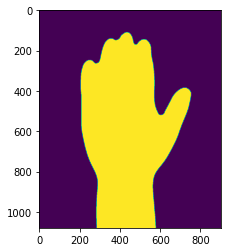

In [8]:
plt.imshow(mask)

In [9]:
# 마스크 기준으로 자르기
def cut_mask(original_img, mask):

    ## 1. 복사
    img_for_cut = original_img.copy()

    ## 2. h,w 값
    height, width = img_for_cut.shape[:2]

    ## 3. mask를 기준으로 자르기
    mask_list = mask.tolist()
    
    for y in range(int(height*0.05),height):
        if max(mask[y,int(width*0.3):int(width*0.7)]) > 0:
            start_y = y-int(height*0.05)
            break
            
    for x in range(int(width*0.05),width):
        if max(mask[int(height*0.3):int(height*0.7),x]) > 0:
            start_x = x-int(width*0.05)
            break
            
    for x in range(int(width*0.95),-1,-1):
        if max(mask[int(height*0.3):int(height*0.7),x]) > 0:
            end_x = x+int(width*0.05)
            break
            
    cut_index = 0
    if mask_list[height-1][-1] == 255 or mask_list[height-1][0] == 255:
        for n in reversed(range(height)):
            if mask_list[n][0] == 0 or mask_list[n][-1] == 0:
                cut_index = n
                break
                
    if cut_index == 0:
        cut_index = height

    ## 4. 그레이스케일 변환
    img_for_cut = cv2.cvtColor(img_for_cut, cv2.COLOR_RGB2BGR)
    img_for_cut = cv2.cvtColor(img_for_cut, cv2.COLOR_BGR2GRAY) 

    img_for_cut = img_for_cut[start_y:(cut_index-1),start_x:end_x]
    mask = mask[start_y:(cut_index-1),start_x:end_x]

    ## 5. 배경 지우기
    masked = cv2.bitwise_and(img_for_cut, mask)

    return masked

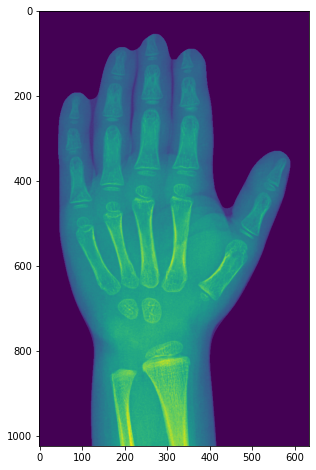

In [10]:
masked = cut_mask(img, mask)
plt.figure(figsize=(10,8))
plt.imshow(masked)

In [ ]:
######## Overlaying - 생략가능 #########

def overlay_contours(masked):
    copied_img = masked.copy()

    ## smoothing
    # cv2.bilateralFilter: 에지가 아닌 부분에서만 blurring
    gray_smooth = cv2.bilateralFilter(copied_img, 7,60,60)

    ## contours
    outline = cv2.Canny(gray_smooth,50,50)

    ## overlay
    overlaied_img = cv2.add(masked,outline)
    return overlaied_img

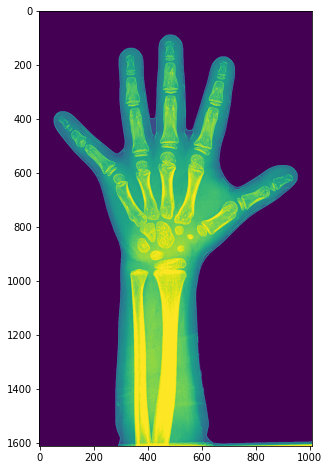

In [ ]:
masked = cut_mask(img, mask)
plt.figure(figsize=(10,8))
plt.imshow(overlay_contours(masked))

In [11]:
# 마스크 기준 회전

def img_rotation(img):
    ## 1. 이미지 가져오기 
    before_rot_img = img.copy()

    ## 2. h,w 값
    h, w = before_rot_img.shape[:2]

    ## 3. 그레이 스케일 변환
    before_rot_img = cv2.cvtColor(before_rot_img, cv2.COLOR_RGB2BGR)
    gray = cv2.cvtColor(before_rot_img, cv2.COLOR_BGR2GRAY)

    ## 4. 임계값으로 이진화
    ret, th = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)
    th_li = th.tolist()


    ## 5. ---------------- 회전 1단계 ------------------ ##
    # 1) lower: 밑에서부터 처음으로 검은 색이 나오는 부분
    for i in reversed(range(h)):
        if th_li[i][0] == 0 and th_li[i][-1] == 0:
            lower = i
            break

    # 1.5) 만약 맨 밑이 lower면 이미지의 95퍼센트 부분을 lower로 정의
    if lower == h - 1:
        lower = int(h*0.9)

    # 2) upper: lower에서 5퍼센트만큼 올라간 부분
    slice5 = int(len(th)*0.05)
    upper = lower - slice5

    # 3) x, y좌표들은 이미지의 90퍼센트(upper)와 95퍼센트(lower) 부분의 손목 가운데 지점들
    x,y = [],[]
    for i in range(slice5):
        cnt = th_li[i + upper].count(255)
        index = th_li[i + upper].index(255)
        x.append([i+upper])
        y.append([int((index*2 + cnt - 1)/2)])

    # 4) x,y좌표로 단순선형회귀 그리기
    model = LinearRegression()
    model.fit(X=x,y=y)

    ## 6. ---------------- 회전 2단계 ------------------ ##
    # 1) cv2.getRotationMatrix2D: 영상의 중앙을 기준점으로 회전 
    angle = math.atan2(h - 0, int(model.predict([[h]])) - int(model.predict([[0]])))*180/math.pi
    M = cv2.getRotationMatrix2D((w/2,h/2), angle-90, 1)
    rotate = cv2.warpAffine(before_rot_img, M, (w, h))

    # 2) 회전한 부분에 맞춰 자르기
    for i in range(len(th[-1])):
        if th[-1][i] == 255:
            start_x = i
            break

    for i in range(len(th[-1])):
        if th[-1][i] == 255:
            end_x = i

    s_point = h - int((int(model.predict([[h]])-start_x)) * math.tan(math.pi*((90-angle)/180)))
    e_point = h - int((end_x - int(model.predict([[h]]))) * math.tan(math.pi*((angle-90)/180)))
    point = max(s_point, e_point)
    rotated_img = rotate[:point]
    return rotated_img

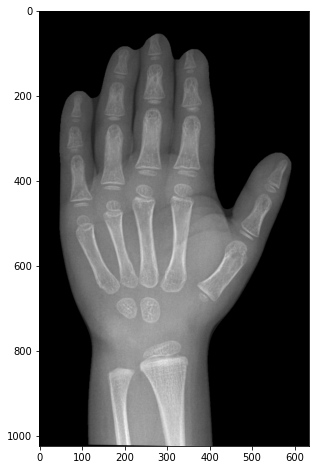

In [12]:
rotated_img = img_rotation(masked)
plt.figure(figsize=(10,8))
plt.imshow(rotated_img)

In [13]:
# contrast 함수
def contrast_roi(img, low, high):
    h, w = img.shape
    img_ = np.zeros(img.shape, dtype=np.uint8)
    for y in range(h):
        for x in range(w):
            temp = int((255 / (high - low)) * (img[y][x] - low))
            if temp > 255:
                img_[y][x] = 255
            elif temp < 0:
                img_[y][x] = 0
            else:
                img_[y][x] = temp
    return img_

In [14]:
# brightness 함수
def bright_ness(img):
  cols, rows = img.shape[:2]
  brightness = np.sum(img) / (255 * cols * rows)
  return brightness

In [15]:
# 뼈만 추출하기
#  img, morphology_value_1, morphology_value_2, filter_value(a,b)

def Extraction(rotated_img,a,b,d,e):

    #-------------- 추출 1 : 밝기, 외곽선 그리기 ---------------#
    ## 1. 이미지 가져오기
    extract_img_1 = rotated_img.copy()

    ## 2. 밝기 조정

    if bright_ness(extract_img_1) > 0.8:
        extract_img_1 = np.clip(extract_img_1 - 80., 0, 255).astype(np.uint8)
    elif bright_ness(extract_img_1) > 0.75:
        extract_img_1 = np.clip(extract_img_1 - 50., 0, 255).astype(np.uint8)
    elif bright_ness(extract_img_1) > 0.65:
        extract_img_1 = np.clip(extract_img_1 - 30., 0, 255).astype(np.uint8)
    else: extract_img_1 = np.clip(extract_img_1 - 10., 0, 255).astype(np.uint8)


    ## 3. Lab 이미지로 변환

    extract_img_1 = cv2.cvtColor(extract_img_1, cv2.COLOR_RGB2BGR)
    extract_img_1 = cv2.cvtColor(extract_img_1, cv2.COLOR_BGR2Lab)

    ## 4. 모폴로지: 노이즈 제거 및 흰부분(뼈) 강조
    # cv2.MORPH_CROSS: 기준점의 열과 행을 모두 1로
    # cv2.MORPH_TOPHAT: 원본이미지와 opening 결과의 차이

    k = cv2.getStructuringElement(cv2.MORPH_CROSS, (a, a))
    extract_img_1 = cv2.morphologyEx(extract_img_1, cv2.MORPH_TOPHAT, k) # Emphasis

    ## 5. 필터(블러)
    # bilateralFilter: 에지가 아닌 부분에서만 blurring 

    extract_img_1 = cv2.bilateralFilter(extract_img_1,-1, d, e)

    ## 6. 이진화를 위한 그레이스케일 변환

    extract_img_1 = cv2.cvtColor(extract_img_1, cv2.COLOR_Lab2BGR)
    extract_img_1 = cv2.cvtColor(extract_img_1, cv2.COLOR_BGR2GRAY)

    ## 7. 이미지 정규화

    extract_img_1 = cv2.normalize(extract_img_1, None, 0, 255, cv2.NORM_MINMAX)

    ## 8. 히스토그램 평탄화: CLAHE
    # 히스토그램 균등화를 이미지 전체에 대해 적용하는게 아닌 일정한 영역을 분리하여 해당 영역에 대한 히스토그램 균등화 연산을 수행

    extract_img_1 = cv2.equalizeHist(extract_img_1)
    clahe = cv2.createCLAHE(clipLimit=1.0, tileGridSize=(3,3)) 
    extract_img_1= clahe.apply(extract_img_1)          


    ## 9. 임계값을 활용한 이진화 
    # Threshold / value = img.mean()
    ret, mask = cv2.threshold(extract_img_1,
                            np.mean(extract_img_1),
                            255,
                            cv2.THRESH_BINARY) 

    ## 10. 외곽선 추출
    # cv2.RETR_EXTERNAL: 바깥 외곽선만 검출
    # cv2.CHAIN_APPROX_SIMPLE Contour vertex coordinate 수평,수직, 대각의 점은 전부 없애고 끝점만 남김(ex 직사각형의 경우 4개의 모서리만 남김)

    contours, hierarchy = cv2.findContours(mask, 
                                            cv2.RETR_EXTERNAL,
                                            cv2.CHAIN_APPROX_SIMPLE) 

    ## 11. 외곽선 그리기
    # drawContours(mask/ contours/ -1: 모든 컨투어 표시 /color/ fill)
    cv2.drawContours(mask, contours, -1, (255,255,255), -1)


        
    #-------------- 추출 2 : 밝기, 명암 조정 ---------------#
    ## 1. 밝기 강조

    extract_img_2 = rotated_img.copy()
    if bright_ness(extract_img_2) > 0.8:
        extract_img_2 = np.clip(extract_img_2 - 80., 0, 255).astype(np.uint8)
    elif bright_ness(extract_img_2) > 0.75:
        extract_img_2 = np.clip(extract_img_2 - 50., 0, 255).astype(np.uint8)
    elif bright_ness(extract_img_2) > 0.65:
        extract_img_2 = np.clip(extract_img_2 - 30., 0, 255).astype(np.uint8)
    else: extract_img_2 = np.clip(extract_img_2 - 10., 0, 255).astype(np.uint8)


    ## 2. 모폴로지
    k2 = cv2.getStructuringElement(cv2.MORPH_CROSS,(b,b))
    extract_img_2 = cv2.morphologyEx(extract_img_2, cv2.MORPH_TOPHAT, k2)

    ## 3. 명암조정
    extract_img_2 = cv2.cvtColor(extract_img_2, cv2.COLOR_BGR2RGB)
    extract_img_2 = cv2.cvtColor(extract_img_2, cv2.COLOR_BGR2GRAY)

    if extract_img_2.mean() <= 15:
        low = extract_img_2.mean() * 3.2
        high = extract_img_2.mean() * 3.6
    elif extract_img_2.mean() <= 20:
        low = extract_img_2.mean() * 3
        high = extract_img_2.mean() * 3.6
    else:
        low = extract_img_2.mean() * 3
        high = extract_img_2.mean() * 3.7

    extract_img_2 = cv2.blur(extract_img_2,(2,2))
    extract_img_2 = contrast_roi(extract_img_2, low, high)


    #-------------- 추출 3 : 뼈강조, 마스크와 비트연산 ---------------#

    ## 1. 외곽선 추출 / 그리기
    contours, hierarchy = cv2.findContours(extract_img_2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(extract_img_2, contours, -1, (255, 255, 255), -1)

    ## 2. 비트연산
    # 흰부분(뼈)만 출력

    extract_img_3 = cv2.bitwise_and(extract_img_2, mask) 

    extract_img_3 = cv2.cvtColor(extract_img_3, cv2.COLOR_GRAY2BGR)
    extract_img_3 = cv2.blur(extract_img_3,(2,2))

    bone_extraction = cv2.resize(extract_img_3, (600, 800))

    return bone_extraction


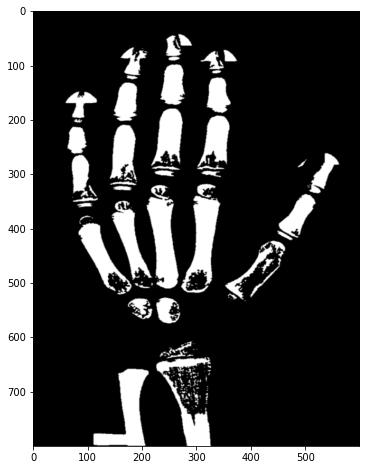

In [16]:
bone_extraction  = Extraction(rotated_img,60,55,50,25)
plt.figure(figsize=(10,8))
plt.imshow(bone_extraction)